# Introduction

This notebook presents **Convolutional Neural Network** applied to [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

**Contents**

* [CIFAR-10 Dataset](#CIFAR-10-Dataset) - load and preprocess dataset
* [Keras Model](#Keras-Model) - make and train model

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets

Pick GPU if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Dataset

PyTorch will download dataset to this location:

In [3]:
dataset_location = '~/.pytorch/CIFAR10_data/'

Download data

In [4]:
trainset = datasets.CIFAR10(dataset_location, download=True, train=True)
testset = datasets.CIFAR10(dataset_location, download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
x_train_raw = torch.tensor(trainset.train_data).float()     # float, 0..255
y_train_raw = torch.tensor(trainset.train_labels)
x_test_raw = torch.tensor(testset.test_data).float()
y_test_raw = torch.tensor(testset.test_labels)
class2txt = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

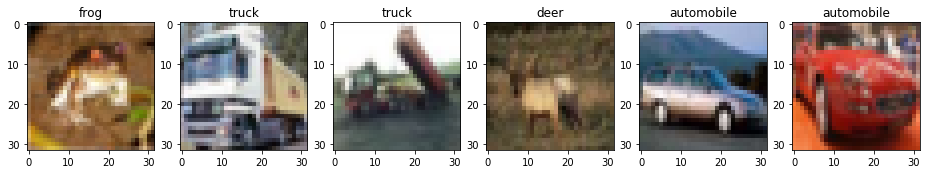

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(class2txt[y_train_raw[i]])
    axes[i].imshow(x_train_raw[i]/255)

Normalize features

In [7]:
x_train = (x_train_raw - x_train_raw.mean()) / x_train_raw.std()
x_test = (x_test_raw - x_train_raw.mean()) / x_train_raw.std()
x_train = x_train.permute(0, 3, 2, 1)    # convert NWHC -> NCHW
x_test = x_test.permute(0, 3, 2, 1) 
print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

x_train.shape torch.Size([50000, 3, 32, 32])
x_test.shape torch.Size([10000, 3, 32, 32])


In [8]:
y_train = y_train_raw  # no conversions
y_test = y_test_raw
print('y_train:')
print('shape', y_train.shape)
print('data')
print(y_train[:20])

y_train:
shape torch.Size([50000])
data
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6])


In [9]:
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

# PyTorch Model

Helper functions

In [10]:
def accuracy(logits, labels): 
    predictions = torch.argmax(logits, dim=1)
    return (predictions == labels).float().mean()  # tensor!!

In [11]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

*Option #1:* define ConvNet using **PyTorch Sequential API**

In [12]:
# model = nn.Sequential(                                                              #      batch, ch,  h,  w
#     nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # shape:   N, 16, 32, 32
#     nn.ELU(),                                                                       # shape:   N, 16, 32, 32
#     nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                               # shape:   N, 16, 16, 16
#     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # shape:   N, 32, 16, 16
#     nn.ELU(),                                                                       # shape:   N, 32, 16, 16
#     nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                               # shape:   N, 32,  8,  8
#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # shape:   N, 64,  8,  8
#     nn.ELU(),                                                                       # shape:   N, 64,  8,  8
#     nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                               # shape:   N, 64,  4,  4
#     Flatten(),                                                                      # shape:   N, 1024
#     nn.Dropout(0.2),
#     nn.Linear(in_features=1024, out_features=512),                                  # shape:   N, 512
#     nn.ELU(),
#     nn.Dropout(0.2),
#     nn.Linear(in_features=512, out_features=10),                                    # shape:   N, 10 
# )
# model.to(device)
# criterion = nn.CrossEntropyLoss()                 # softmax included in here
# optimizer = torch.optim.Adam(model.parameters())
# print(model)

*Option #2:* define ConvNet using **PyTorch Model API**

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.lin1 = nn.Linear(in_features=1024, out_features=512)
        self.lin2 = nn.Linear(in_features=512, out_features=10)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.maxpool(F.elu(self.conv1(x)))
        x = self.maxpool(F.elu(self.conv2(x)))
        x = self.maxpool(F.elu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = F.elu(self.lin1(x))
        x = self.drop(x)
        x = self.lin2(x)  # no activation after last linear
        return x

model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()                 # softmax included in here
optimizer = torch.optim.Adam(model.parameters())
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=1024, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=10, bias=True)
  (drop): Dropout(p=0.2)
)


Train model

In [15]:
batch_size = 250
num_epochs = 20
hist = { 'loss':[], 'acc':[],              # mini-batch loss/acc every iteration
         'train_loss':[], 'train_acc':[],   # train set loss/acc every epoch
         'val_loss':[], 'val_acc':[] }      # valid set loss/acc every epoch

for epoch in range(num_epochs):
    
    # train: one full pass over dataset
    model.train()                                                  # enable dropout etc.
    indices = torch.randperm(len(x_train), device=device)          # randmly shuffled indices [0..59999]
    for i in range(0, len(x_train), batch_size):                   # i = 0, 1000, 2000, 3000, ...
        
        # Pick mini-batch
        x = x_train[indices[i:i+batch_size]]
        y = y_train[indices[i:i+batch_size]]
        
        # Zero gradients
        optimizer.zero_grad()

        # Train
        outputs = model(x)                                         # outputs is un-normalized, i.e. no softmax
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            acc = accuracy(outputs, y)                             # max(outputs) is the same as max(softmax(outputs))
            hist['acc'].append( acc.item() )
            hist['loss'].append( loss.item() )
            
    # eval: once after each epoch
    with torch.no_grad():
        model.eval()                                               # disable dropout etc.
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        acc = accuracy(outputs, y_train)
        hist['train_acc'].append( acc.item() )
        hist['train_loss'].append( loss.item() )
        
        outputs = model(x_test)
        loss = criterion(outputs, y_test)
        acc = accuracy(outputs, y_test)
        hist['val_acc'].append( acc.item() )
        hist['val_loss'].append( loss.item() )
        
        print(f'Epoch {epoch}/{num_epochs}')

Epoch 0/20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20


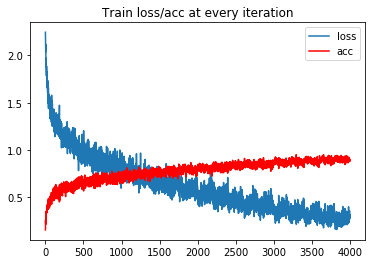

In [16]:
plt.plot(hist['loss'], label='loss')
plt.plot(hist['acc'], label='acc', color='red')
plt.title('Train loss/acc at every iteration')
plt.legend();

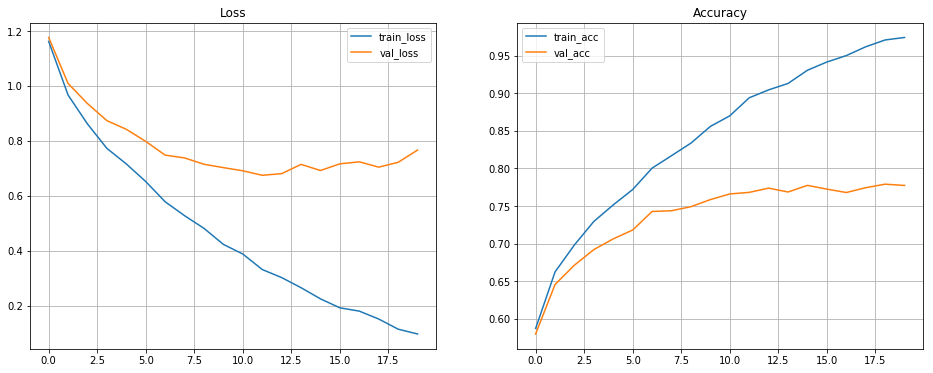

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16, 6])
axes[0].plot(hist['train_loss'], label='train_loss')
axes[0].plot(hist['val_loss'], label='val_loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid()
axes[1].plot(hist['train_acc'], label='train_acc')
axes[1].plot(hist['val_acc'], label='val_acc')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid()

# Graph Visualization

Functions in this section are copy-pasted from [https://github.com/szagoruyko/pytorchviz](https://github.com/szagoruyko/pytorchviz)

You will need to install python-graphviz for this section to work

In [18]:
from graphviz import Digraph

Also, code behind the link was not yet ported to PyTorch 1.0, so we need to import Variable (which is now merged with Tensor)

In [19]:
from torch.autograd import Variable

Following two functions make pretty graph

In [20]:
# Copied from https://github.com/szagoruyko/pytorchviz
def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph.
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert all(isinstance(p, Variable) for p in params.values())
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '(' + (', ').join(['%d' % v for v in size]) + ')'

    output_nodes = (var.grad_fn,) if not isinstance(var, tuple) else tuple(v.grad_fn for v in var)

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                # note: this used to show .saved_tensors in pytorch0.2, but stopped
                # working as it was moved to ATen and Variable-Tensor merged
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            elif var in output_nodes:
                dot.node(str(id(var)), str(type(var).__name__), fillcolor='darkolivegreen1')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)

    # handle multiple outputs
    if isinstance(var, tuple):
        for v in var:
            add_nodes(v.grad_fn)
    else:
        add_nodes(var.grad_fn)

    resize_graph(dot)

    return dot

In [21]:
# Copied from https://github.com/szagoruyko/pytorchviz
def resize_graph(dot, size_per_element=0.15, min_size=12):
    """Resize the graph according to how much content it contains.
    Modify the graph in place.
    """
    # Get the approximate number of nodes and edges
    num_rows = len(dot.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    dot.graph_attr.update(size=size_str)

**Actually create graph**

To build graph in pytorch we need to pass actuall mini-batch in

In [22]:
x, y = x_train[0:250], y_train[0:250]               # construct mini-batch
x.requires_grad = True                              # mark requires_grad, otherwise 'x' won't show on the graph
outputs = model(x)                                  # do forward pass - graph gets constructed

PyTorch tensors don't have names, so to see names on the graph we need to pass dictinary of name->tensor. We can pull out names for all weights and biases from the model.named_parameters(). We need to add 'x' manually, because it's not weight.

In [23]:
params = dict(model.named_parameters())
params['x'] = x

Create graph

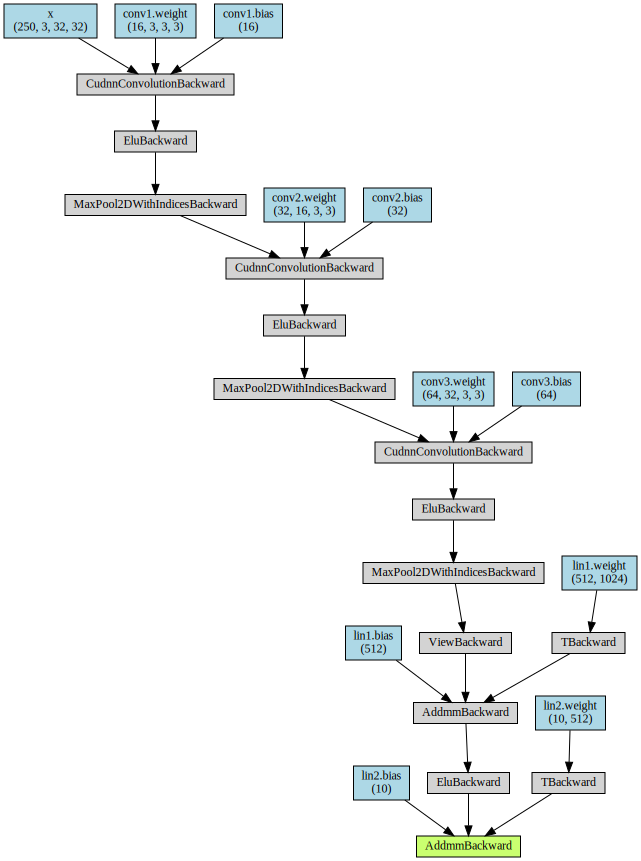

In [24]:
make_dot(outputs, params=params)

Taa daa!